In [1]:
%%capture
!pip install transformers
!pip install datasets

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from imblearn import under_sampling
from datasets import load_dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = load_dataset("tweets_hate_speech_detection")

Using custom data configuration default


Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Dataset tweets_hate_speech_detection downloaded and prepared to /root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
dataset['train']

Dataset({
    features: ['label', 'tweet'],
    num_rows: 31962
})

In [6]:
df_1 = pd.DataFrame(columns = ['class','tweet'])
df_1['tweet'] = dataset['train']['tweet']
df_1['class'] = dataset['train']['label']

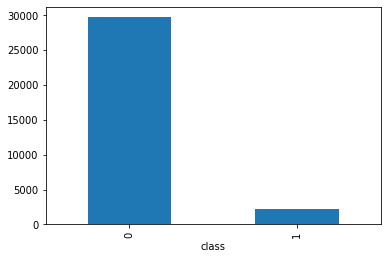

In [7]:
df_1.groupby(['class']).size().plot.bar()

In [8]:
df = df_1[['class','tweet']].copy(deep=True)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {0:0,
          1:1,
          2:2,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['class']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 100, truncation=True,
                                return_tensors="pt") for text in df['tweet']]
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.relu(dropout_output)
        final_layer = self.linear(linear_output)

        return final_layer

In [11]:
def train(model, train_data, val_data, learning_rate, epochs,batch):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [12]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    return total_acc_test / len(test_data)

In [13]:
np.random.seed(112)
df = df.sample(n=10000)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

8000 1000 1000


In [14]:
EPOCHS = [1,2]
BATCHES = [2,16,32,64]
results = pd.DataFrame(columns = ['Epochs','Batch_size','Test_accuracy'])

for epoch in EPOCHS:
  for batch in BATCHES:
    model = BertClassifier()
    LR = 1e-6
    train(model, df_train, df_val, LR, epoch,batch)
    acc = evaluate(model, df_test)
    results = results.append({'Epochs':epoch,'Batch_size':batch,'Test_accuracy': acc}, ignore_index=True)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4000/4000 [11:29<00:00,  5.80it/s]


Epochs: 1 | Train Loss:  0.116 | Train Accuracy:  0.927 | Val Loss:  0.072 | Val Accuracy:  0.940


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 500/500 [04:22<00:00,  1.91it/s]


Epochs: 1 | Train Loss:  0.024 | Train Accuracy:  0.875 | Val Loss:  0.016 | Val Accuracy:  0.938


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 250/250 [03:55<00:00,  1.06it/s]


Epochs: 1 | Train Loss:  0.016 | Train Accuracy:  0.757 | Val Loss:  0.010 | Val Accuracy:  0.932


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


Epochs: 1 | Train Loss:  0.009 | Train Accuracy:  0.716 | Val Loss:  0.008 | Val Accuracy:  0.868


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4000/4000 [11:30<00:00,  5.79it/s]


Epochs: 1 | Train Loss:  0.118 | Train Accuracy:  0.932 | Val Loss:  0.076 | Val Accuracy:  0.944


100%|██████████| 4000/4000 [11:29<00:00,  5.80it/s]


Epochs: 2 | Train Loss:  0.066 | Train Accuracy:  0.954 | Val Loss:  0.061 | Val Accuracy:  0.957


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 500/500 [04:22<00:00,  1.91it/s]


Epochs: 1 | Train Loss:  0.024 | Train Accuracy:  0.876 | Val Loss:  0.015 | Val Accuracy:  0.938


100%|██████████| 500/500 [04:22<00:00,  1.91it/s]


Epochs: 2 | Train Loss:  0.013 | Train Accuracy:  0.933 | Val Loss:  0.011 | Val Accuracy:  0.938


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 250/250 [03:56<00:00,  1.06it/s]


Epochs: 1 | Train Loss:  0.014 | Train Accuracy:  0.867 | Val Loss:  0.009 | Val Accuracy:  0.938


100%|██████████| 250/250 [03:55<00:00,  1.06it/s]


Epochs: 2 | Train Loss:  0.008 | Train Accuracy:  0.933 | Val Loss:  0.007 | Val Accuracy:  0.938


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


Epochs: 1 | Train Loss:  0.011 | Train Accuracy:  0.572 | Val Loss:  0.008 | Val Accuracy:  0.868


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


Epochs: 2 | Train Loss:  0.006 | Train Accuracy:  0.916 | Val Loss:  0.004 | Val Accuracy:  0.936


In [15]:
evaluate(model, df_test)

0.926

In [16]:
df_test.iloc[7,1]

'i am thankful for stars. #thankful #positive     '

In [17]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model(Dataset(df_test)[7][0]['input_ids'].to(device), Dataset(df_test)[7][0]['attention_mask'].to(device))

tensor([[ 1.5291, -0.6256]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [18]:
results

,Epochs,Batch_size,Test_accuracy
0,1.0,2.0,0.935
1,1.0,16.0,0.930
2,1.0,32.0,0.926
3,1.0,64.0,0.881
4,2.0,2.0,0.938
5,2.0,16.0,0.930
6,2.0,32.0,0.930
7,2.0,64.0,0.926
